In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import os
import pandas as pd
import seaborn as sns
import random

In [2]:
X_train = np.genfromtxt('sliced_data/window-200-step-10/combined/X_train.csv', delimiter=',')
y_train = np.genfromtxt('sliced_data/window-200-step-10/combined/y_train.csv', delimiter=',')
X_test = np.genfromtxt('sliced_data/window-200-step-10/combined/X_test.csv', delimiter=',')
y_test = np.genfromtxt('sliced_data/window-200-step-10/combined/y_test.csv', delimiter=',')
X_val = np.genfromtxt('sliced_data/window-200-step-10/combined/X_val.csv', delimiter=',')
y_val = np.genfromtxt('sliced_data/window-200-step-10/combined/y_val.csv', delimiter=',')

In [3]:
scaler = MinMaxScaler()

with open('r_clf_best.sav', 'rb') as f:
    clf = pickle.load(f)
    
meta = pd.read_csv('../Artificial_data/DOGEx_v1/synthetic-meta.txt', sep=',', header=None)
meta.columns = ['station', 'direction', 'date']
z_meta = meta[meta.direction == 'Z']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
X_test[0:1,:].shape

(1, 200)

In [5]:
y_pred = clf.predict(X_test[0:1,:])

In [6]:
y_test[0:1].shape

(1,)

In [7]:
print(classification_report(y_test[0:1], y_pred))
confusion_matrix(y_test[0:1], y_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



array([[1]])

In [8]:
clf.predict(X_test[0:1])

array([0.])

# Using real dataset on 7ODM

In [123]:
df = pd.read_csv('../real_data/7ODM.csv')
df.head()

,site,YYMMMDD,yyyy.yyyy,__MJD,week,d,reflon,_e0(m),__east(m),____n0(m),_north(m),u0(m),____up(m),_ant(m),sig_e(m),sig_n(m),sig_u(m),__corr_en,__corr_eu,__corr_nu
0,7ODM,01APR20,2001.3005,52019,1110,5,-117.1,628,0.084091,3776573,0.697518,762,0.071883,0.0083,0.000892,0.001017,0.004000,-0.100505,-0.267313,0.097294
1,7ODM,01APR21,2001.3032,52020,1110,6,-117.1,628,0.086470,3776573,0.698739,762,0.068410,0.0083,0.000930,0.001035,0.003984,-0.108289,-0.229542,0.066488
2,7ODM,01APR22,2001.3060,52021,1111,0,-117.1,628,0.087425,3776573,0.700625,762,0.054435,0.0083,0.000943,0.001084,0.004008,-0.080530,-0.260986,0.076587
3,7ODM,01JUN03,2001.4209,52063,1117,0,-117.1,628,0.080423,3776573,0.697773,762,0.071509,0.0083,0.000877,0.001022,0.003857,-0.128355,-0.259917,0.044449
4,7ODM,01JUN04,2001.4237,52064,1117,1,-117.1,628,0.081143,3776573,0.698180,762,0.069169,0.0083,0.000893,0.001044,0.003811,-0.101738,-0.260853,0.039822


In [124]:
df.drop(['site', 'YYMMMDD', '__MJD', 'week', 'd', 'reflon', '_e0(m)', '____n0(m)', 'u0(m)', '_ant(m)', 'sig_e(m)', 'sig_n(m)', 'sig_u(m)', '__corr_en', '__corr_eu', '__corr_nu'], axis=1, inplace=True)

In [125]:
df.head()

,yyyy.yyyy,__east(m),_north(m),____up(m)
0,2001.3005,0.084091,0.697518,0.071883
1,2001.3032,0.086470,0.698739,0.068410
2,2001.3060,0.087425,0.700625,0.054435
3,2001.4209,0.080423,0.697773,0.071509
4,2001.4237,0.081143,0.698180,0.069169


In [126]:
df.columns = ['date', 'un', 'ue', 'uz']

In [127]:
df = df[['date','un']]

In [128]:
un_scaled = scaler.fit_transform(df['un'].to_numpy().reshape(-1, 1))

In [129]:
df['un'] = un_scaled

In [130]:
df

,date,un
0,2001.3005,0.987628
1,2001.3032,0.992207
2,2001.3060,0.994045
3,2001.4209,0.980569
4,2001.4237,0.981955
...,...,...
5926,2021.1581,0.003164
5927,2021.1608,0.004394
5928,2021.1636,0.003274
5929,2021.1663,0.003564


<AxesSubplot:xlabel='date', ylabel='un'>

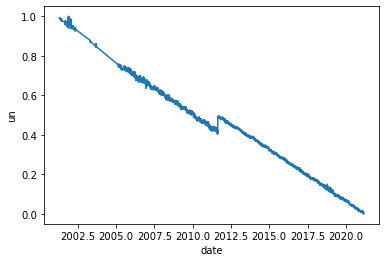

In [131]:
sns.lineplot(x = 'date', y = "un", data = df)

In [134]:
meta = pd.read_csv('../real_data/metadata.csv')
meta.columns = ["index", "station", "yyyy.yyyy", "type", "description", "unknown", "magnitude"]
meta.set_index("index", inplace=True)
offset_dates = meta[meta.station=="7ODM"]["yyyy.yyyy"]

In [167]:
def generate_visual (station, df):
    offset_dates = meta[meta.station==station]["yyyy.yyyy"]
    window_size = 200
    interval_size = 10
    pred_dates = []   

    i = 0 
    while i < df.shape[0] - window_size:
        pred = clf.predict(np.array(df.iloc[i:i+window_size]['un']).reshape(1,-1))

        if pred == 1:
            pred_dates.append(df.iloc[i+int(window_size/2), 0])    

        i += interval_size


    fig, ax = plt.subplots(figsize=(12, 6))

    np.random.seed(42)
    x = np.random.rand(150)
    plt.plot(df.set_index('date'), label='uz');
    plt.xticks(rotation=25);
    plt.legend();

    ax.vlines(pred_dates, 0, 1, colors='red', alpha=0.3)
    ax.vlines(list(offset_dates), 0, 1, colors='black', linewidth=4)

# Using real dataset on random sample of dataset

In [4]:
files = os.listdir('../real_data/csv/')

In [5]:
def datavis_func ():
    df = pd.read_csv('../real_data/csv/' + files[random.randrange(1, len(files))])
    df.drop(['site', 'YYMMMDD', '__MJD', 'week', 'd', 'reflon', '_e0(m)', '____n0(m)', 'u0(m)', '_ant(m)', 'sig_e(m)', 'sig_n(m)', 'sig_u(m)', '__corr_en', '__corr_eu', '__corr_nu'], axis=1, inplace=True)
    df.columns = ['date', 'un', 'ue', 'uz']
    df = df[['date','un']]
    un_scaled = scaler.fit_transform(df['un'].to_numpy().reshape(-1, 1))
    df['un'] = un_scaled
    
    station = files[random.randrange(1, len(files))][0:4]
    generate_visual(station, df)

In [6]:
datavis()

NameError: name 'datavis' is not defined

That took 347.3818850517273 seconds


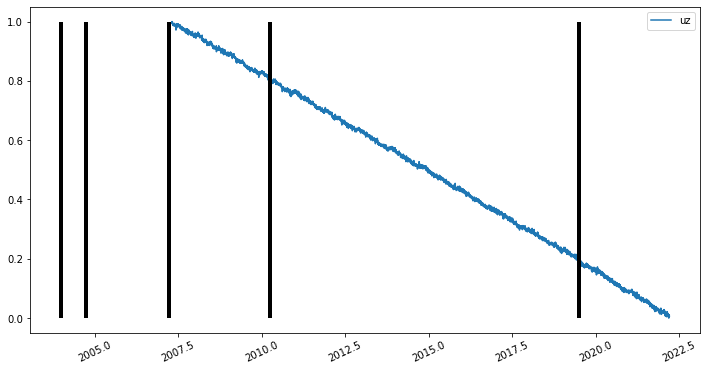

In [189]:
for i in range (1, 2):
    starttime = time.time()
    datavis_func()
    print('That took {} seconds'.format(time.time() - starttime))

In [190]:
def square_num_func(x):
    return x * x

In [9]:
import multiprocessing 
import real_data_vis_funcs

In [10]:
starttime = time.time()
processes = []
for i in range(0,50):
    p = multiprocessing.Process(target=real_data_vis_funcs.datavis_func)
    processes.append(p)
    p.start()

for process in processes:
    process.join()

print('That took {} seconds'.format(time.time() - starttime))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested

That took 3117.913690805435 seconds


# Datagen 

In [ ]:
# set sliding window settings
interval_size = 200
offset = 100


#run through each file in csv dir, 
#      calculate the total # of files, total # of windows, 
#      the name of each csv, and the windows per csv 
num_files = 0
tot_ranges = 0

csv_list = []
ranges_per_csv = []
   
num_ranges = (sum(1 for line in open('../real_data/7ODM.csv')) - interval_size) // offset

csv_list.append('7ODM.csv')
ranges_per_csv.append(num_ranges)

tot_ranges += num_ranges
num_files +=  1
    
# create empty numpy array     
ranges = np.empty((tot_ranges, 3), dtype=np.ndarray)

# run through each file and place each range into the ranges array
range_row = 0
csv_idx = 0
while range_row < tot_ranges:
    # df, offset_dates = process_csv('csv/'+csv_list[csv_idx])    
    i = 0
    while i < ranges_per_csv[csv_idx]:
        arr = np.array(df.iloc[i * offset:i * offset + interval_size].T)
        ranges[range_row] = (arr[0], arr[1], 0)

        i = i + 1  
        range_row = range_row + 1   
    
    csv_idx += 1
    

data = pd.DataFrame(ranges)
data.columns = ['dates', 'un', 'label']
regular = data[data.label == 0]
offsets  = data[data.label == 1]
X = ranges[:, 1]

In [243]:
station = 'TBLP'
df = pd.read_csv('../real_data/csv/' + 'TBLP.csv')
df.drop(['site', 'YYMMMDD', '__MJD', 'week', 'd', 'reflon', '_e0(m)', '____n0(m)', 'u0(m)', '_ant(m)', 'sig_e(m)', 'sig_n(m)', 'sig_u(m)', '__corr_en', '__corr_eu', '__corr_nu'], axis=1, inplace=True)
df.columns = ['date', 'un', 'ue', 'uz']

un = df[['date','un']]
ue = df[['date','ue']]
uz = df[['date','uz']]
un_scaled = scaler.fit_transform(df['un'].to_numpy().reshape(-1, 1))
ue_scaled = scaler.fit_transform(df['ue'].to_numpy().reshape(-1, 1))
uz_scaled = scaler.fit_transform(df['uz'].to_numpy().reshape(-1, 1))

df['un'] = un_scaled
df['ue'] = ue_scaled
df['uz'] = uz_scaled

In [264]:
df.shape

(6667, 4)

In [275]:
rows_to_keep[-1]

3331

In [276]:
df.shape

(1111, 4)

In [1]:
np.random.seed(42)
x = np.random.rand(150)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df[['date', 'un']].set_index('date'), label='un');
plt.legend()
#ax.vlines(un_pred_dates, 0, 1, colors='red', alpha=0.3)
ax.vlines(list(offset_dates), 0, 1, colors='brown', linewidth=4)
ax.vlines(list(eq_dates), 0, 1, colors='green', linewidth=4)

plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df[['date', 'ue']].set_index('date'), label='ue');
plt.legend()
#ax.vlines(ue_pred_dates, 0, 1, colors='red', alpha=0.3)
ax.vlines(list(offset_dates), 0, 1, colors='brown', linewidth=4)
ax.vlines(list(eq_dates), 0, 1, colors='green', linewidth=4)

plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df[['date', 'uz']].set_index('date'), label='uz');
plt.legend()
#ax.vlines(uz_pred_dates, 0, 1, colors='red', alpha=0.3)
ax.vlines(list(offset_dates), 0, 1, colors='brown', linewidth=4)
ax.vlines(list(eq_dates), 0, 1, colors='green', linewidth=4)

plt.xticks(rotation=25);
plt.legend();

NameError: name 'np' is not defined